# Libraries importing

In [1]:
from collections import defaultdict
import math
import os
import pickle
import requests
import sys
import warnings

import catboost
from catboost import CatBoostRegressor, Pool
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Scikit-learn:'.ljust(16), sklearn.__version__)
print('CatBoost:'.ljust(16), catboost.__version__)

Python:          3.10.9 (v3.10.9:1dd9be6584, Dec  6 2022, 14:37:36) [Clang 13.0.0 (clang-1300.0.29.30)]
Scikit-learn:    1.3.0
CatBoost:        1.2.1


In [2]:
# Save requirements
!pip freeze > requirements.txt

# Constants definition

In [3]:
DATA_PATH = './data/'
MODELS_PATH = './models/'
RANDOM_STATE = 424242
VALIDATION_SIZE = 0.2

TRAIN = 'TRAIN'  # Feature to separate training and validation parts
TARGET = 'Цена'  # Target feature

# Dataset parsing

In [4]:
def get_links(base_url, pages):
    links = []
    for page in pages:
        # Get response from page
        response = requests.get(url + str(page))

        # Check response status
        if response.status_code == 200:
            print(f'Page {page} received')

            # Find links on a page
            soup = BeautifulSoup(response.content, 'html.parser')
            for a in soup.find_all(class_='adv-list-image__link'):
                links.append('http://citystar.ru/' + a['href'])
        else:
            print(f'Page {page} error: code {response.status_code}')

    return links


def get_data_from_links(links):
    data = defaultdict(list)
    for link in links:
        # Append link to data
        data['link'].append(link)
        
        # Get response from page
        response = requests.get(link)
        
        # Check response status
        if response.status_code == 200:
            # Find data on a page
            soup = BeautifulSoup(response.content, 'html.parser')
            soup = soup.find(class_='data-table')
            soup = soup.find_all(class_='fin')
            for k, v in zip(soup[0::2], soup[1::2]):
                data[str(k.contents[0])].append(str(v.contents[0]) if len(v.contents) > 0 else None)
        else:
            print(f'Page {link} error: code {response.status_code}')

    return pd.DataFrame(data)

In [5]:
%%time
data_file = DATA_PATH + 'data.pickle'
url = 'http://citystar.ru/detal.htm?d=43&pN='
pages = range(1, 6)

# Check if data file is already exists
if os.path.isfile(data_file):
    # Load data from disk
    df = pd.read_pickle(data_file)
else:
    # Parse data from the Internet
    links = get_links(url, pages)
    df = get_data_from_links(links)

    # Save data to disk
    df.to_pickle(data_file)

CPU times: user 3.33 ms, sys: 2.74 ms, total: 6.07 ms
Wall time: 6.54 ms


In [6]:
df.head()

,link,Дата подачи,Дата обновления,Примечание,Тип квартиры,Район,Адрес,Дом,Этаж,Планировка,о,ж,к,цена (т.р.),Телефон,Имя,E-mail,Просмотров:
0,http://citystar.ru/scard.asp?d=43&id=15909831,30.08.2023 15:22:27,02.09.2023 14:03:02,В продаже 4-х комнатная квартира. С хорошим ре...,Трехкомнатная,Орджоникидзевский,Труда,14,8/9,None,80.00,53.00,9.00,5999,8-902-619-83-08,Юлия Юрьевна,None,40
1,http://citystar.ru/scard.asp?d=43&id=15909830,30.08.2023 14:57:57,02.09.2023 14:02:56,Продается 4-х комнатная квартира нестандартной...,Четырехкомнатная,Орджоникидзевский,Труда,18,9/9,None,79.00,52.70,8.20,6350,8-902-619-83-08,Юлия Юрьевна,None,27
2,http://citystar.ru/scard.asp?d=43&id=15927949,02.09.2023 14:02:00,02.09.2023 14:02:21,Продам 3-х комнатную квартиру\r\nпремиум-класс...,Трехкомнатная,Орджоникидзевский,Ленина пр-т,129/2,6/9,None,105.00,78.00,14.00,8700,89026198308,Юлия Юрьевна,None,6
3,http://citystar.ru/scard.asp?d=43&id=15927071,02.09.2023 8:11:48,02.09.2023 8:11:48,id:26867. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,Многокомнатная,None,Калмыкова,14,8/9,None,65.00,45.00,8.00,4800,79193209269,Руслан Жаксалыков,ruslanjaksalykov.riolux@gmail.com,10
4,http://citystar.ru/scard.asp?d=43&id=15927070,02.09.2023 8:11:47,02.09.2023 8:11:47,id:26185. \r\nП продаже отличная двухкомнатная...,Двухкомнатная,None,Суворова,136/1,2/5,None,44.30,30.00,6.00,2980,79026009666,Алия Тугузова,tuguzova.riolux@gmail.com,7


# Dataset preprocessing

In [7]:
# Set housing ID as an index
df['id'] = df['link'].str.split('=', regex=False, expand=True)[2].astype(int)
df.set_index('id', inplace=True, verify_integrity=True)

# Expand 'Этаж' column
df[['Этаж', 'Этажей']] = df['Этаж'].str.split('/', regex=False, expand=True).astype(int)

# Cast column types
df['цена (т.р.)'] = df['цена (т.р.)'].astype(int)
df[['о', 'ж', 'к']] = df[['о', 'ж', 'к']].astype(float)

# Drop useless columns
columns = ['link', 'Дата подачи', 'Дата обновления', 'Примечание', 'Дом', 'Телефон', 'Имя', 'E-mail', 'Просмотров:']
df.drop(columns=columns, inplace=True)

# Rename column
df.rename(columns={'цена (т.р.)': TARGET}, inplace=True)
df.rename(columns={'Адрес': 'Улица'}, inplace=True)

# Drop rows without 'Тип квартиры'
nan_indices = df.loc[df['Тип квартиры'].isna()].index
df.drop(nan_indices, inplace=True)

# Drop rows where 'Цена' equals to zero
zero_price_indices = df.loc[df[TARGET] == 0].index
df.drop(zero_price_indices, inplace=True)

# Change wrong values
df.loc[df['Этаж'] == -1, 'Этаж'] = 1
df.loc[df['Район'] == 'орджоникидзевский', 'Район'] = 'Орджоникидзевский'
df.loc[df['Район'] == 'Ленинский (Левый берег)', 'Район'] = 'Ленинский'
df.loc[df['Район'] == 'правобережный', 'Район'] = 'Правобережный'
df.loc[df['Район'] == 'Правобережный район', 'Район'] = 'Правобережный'
df.loc[df['Планировка'] == 'Улучшенная', 'Планировка'] = 'улучшенная'
df['Улица'] = df['Улица'].str.lower()
df['Улица'] = df['Улица'].str.replace('ул ', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('ул.', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace(r'\d+', '', regex=True)
df['Улица'] = df['Улица'].str.replace(r'[.,/"-]', '', regex=True)
df['Улица'] = df['Улица'].str.replace('прт', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('проспект', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('им ', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('имени ', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace(' к', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.strip()

# Split dataframe on train and validation parts
_, valid_idx = train_test_split(
    range(len(df)),
    test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['Тип квартиры'],
)
df[TRAIN] = True
df.loc[df.iloc[valid_idx].index, TRAIN] = False

In [8]:
df.head()

,Тип квартиры,Район,Улица,Этаж,Планировка,о,ж,к,Цена,Этажей,TRAIN
id,,,,,,,,,,,
15909831,Трехкомнатная,Орджоникидзевский,труда,8,None,80.0,53.0,9.0,5999,9,True
15909830,Четырехкомнатная,Орджоникидзевский,труда,9,None,79.0,52.7,8.2,6350,9,True
15927949,Трехкомнатная,Орджоникидзевский,ленина,6,None,105.0,78.0,14.0,8700,9,True
15927071,Многокомнатная,None,калмыкова,8,None,65.0,45.0,8.0,4800,9,True
15927070,Двухкомнатная,None,суворова,2,None,44.3,30.0,6.0,2980,5,True


**Comments**
___
Make a deep copy of the dataframe to use it with linear ML methods. Trees based methods are not sensitive to outliers, scale, linear dependense and some of theese can work with missing values.

In [9]:
# Make a deep copy of the dataframe to use it with linear ML methods
df_linear_ml = df.copy()

# Exploratory data analysis
## General info
### Dataframe info

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 15909831 to 12926993
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Тип квартиры  456 non-null    object 
 1   Район         286 non-null    object 
 2   Улица         452 non-null    object 
 3   Этаж          456 non-null    int64  
 4   Планировка    123 non-null    object 
 5   о             456 non-null    float64
 6   ж             456 non-null    float64
 7   к             456 non-null    float64
 8   Цена          456 non-null    int64  
 9   Этажей        456 non-null    int64  
 10  TRAIN         456 non-null    bool   
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 55.8+ KB


In [11]:
print('Number of unique ids:', df.index.nunique())

Number of unique ids: 456


In [12]:
print('Number of training objects:  ', len(df.loc[df[TRAIN]]))
print('Number of validation objects:', len(df.loc[~df[TRAIN]]))

Number of training objects:   364
Number of validation objects: 92


### Value counts

In [13]:
categ_columns = ['Тип квартиры', 'Район', 'Улица', 'Планировка']

for column in categ_columns:
    print(df[column].value_counts())
    print()

Тип квартиры
Двухкомнатная       173
Трехкомнатная       142
Однокомнатная       113
Четырехкомнатная     21
Многокомнатная        7
Name: count, dtype: int64

Район
Орджоникидзевский                  113
Ленинский                           86
Правобережный                       75
Орджоникидзевский (левый берег)     12
Name: count, dtype: int64

Улица
ленина          67
карла маркса    55
советская       19
зеленый лог     19
труда           16
                ..
корсикова        1
уйбышева         1
тургенева        1
достоевского     1
дружбы           1
Name: count, Length: 99, dtype: int64

Планировка
улучшенная              24
брежневка               22
нестандартная           20
старой планировки       17
раздельная              11
хрущевка                 7
сталинский вариант       5
свердловский вариант     4
ленинградский проект     3
малосемейка              3
гребенка                 3
полусмежная              1
полустудия               1
распашонка               1
студия  

In [14]:
df['Этаж'].value_counts()

Этаж
1     112
2      95
5      75
3      57
4      39
7      26
9      17
6      17
8       8
13      3
10      3
14      2
11      2
Name: count, dtype: int64

In [15]:
df['Этажей'].value_counts()

Этажей
5     145
9      84
3      53
10     42
4      39
2      38
1      23
14     14
16      9
12      3
8       2
13      1
6       1
17      1
7       1
Name: count, dtype: int64

## Correlation analysis
### Correlation matrix

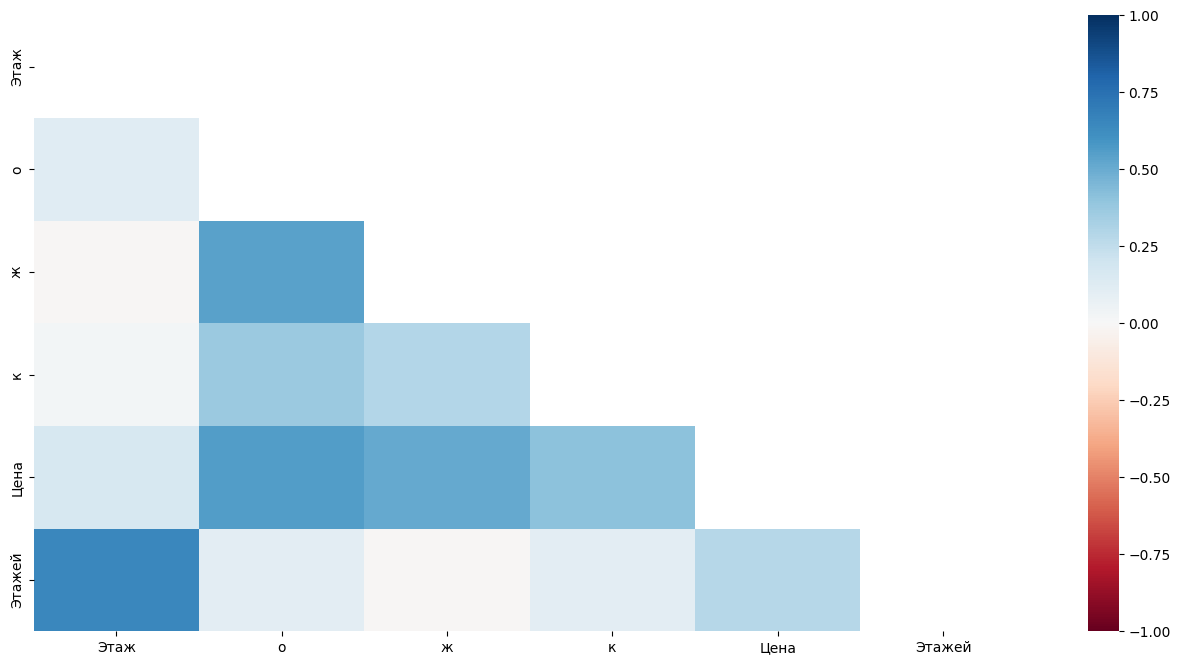

In [16]:
# Compute correlation table
corr = df.drop(columns=categ_columns + [TRAIN]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.subplots(figsize=(16, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="RdBu");

### Correlation with target

In [17]:
# Sort absolute correlation values with target variable
corr[TARGET].abs().sort_values(ascending=False)

Цена      1.000000
о         0.559677
ж         0.510923
к         0.406383
Этажей    0.284088
Этаж      0.168814
Name: Цена, dtype: float64

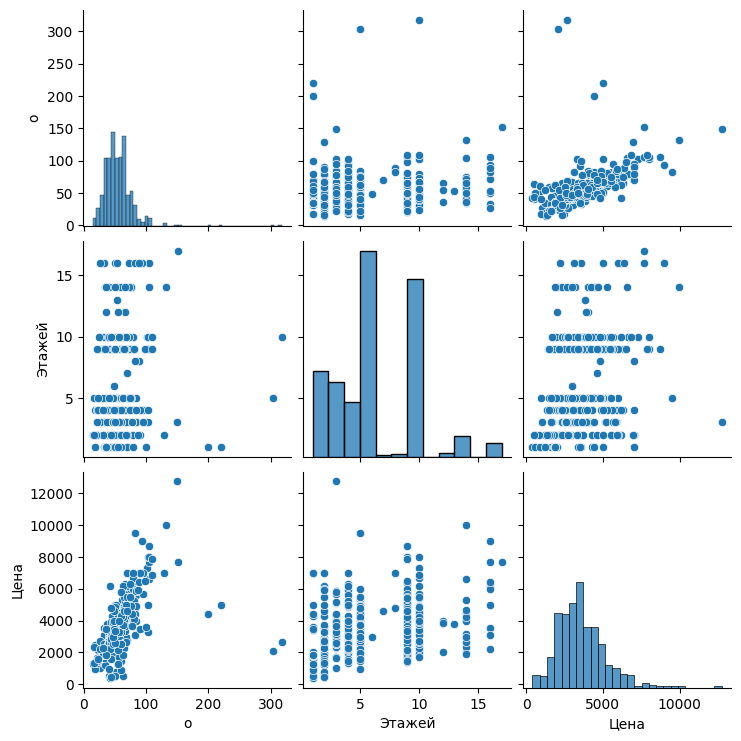

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.pairplot(df[['о', 'Этажей', TARGET]]);

### Searching for strong correlations

In [19]:
# Correlation threshold
corr_threshold = 0.90

# Triangle mask
triangle_mask = np.triu(np.ones_like(corr, dtype=bool))

# Mask correlations below threshold value
corr_mask = corr.mask(triangle_mask).where(corr.abs() > corr_threshold)

# Show onle strong correlations
strong_corr = corr_mask.dropna(axis=0, how='all').dropna(axis=1, how='all')
strong_corr

""


**Comments**
___
There is no strong correlation values that can interfere with calculations by linear models.

## Missing values
### Showing of missing values

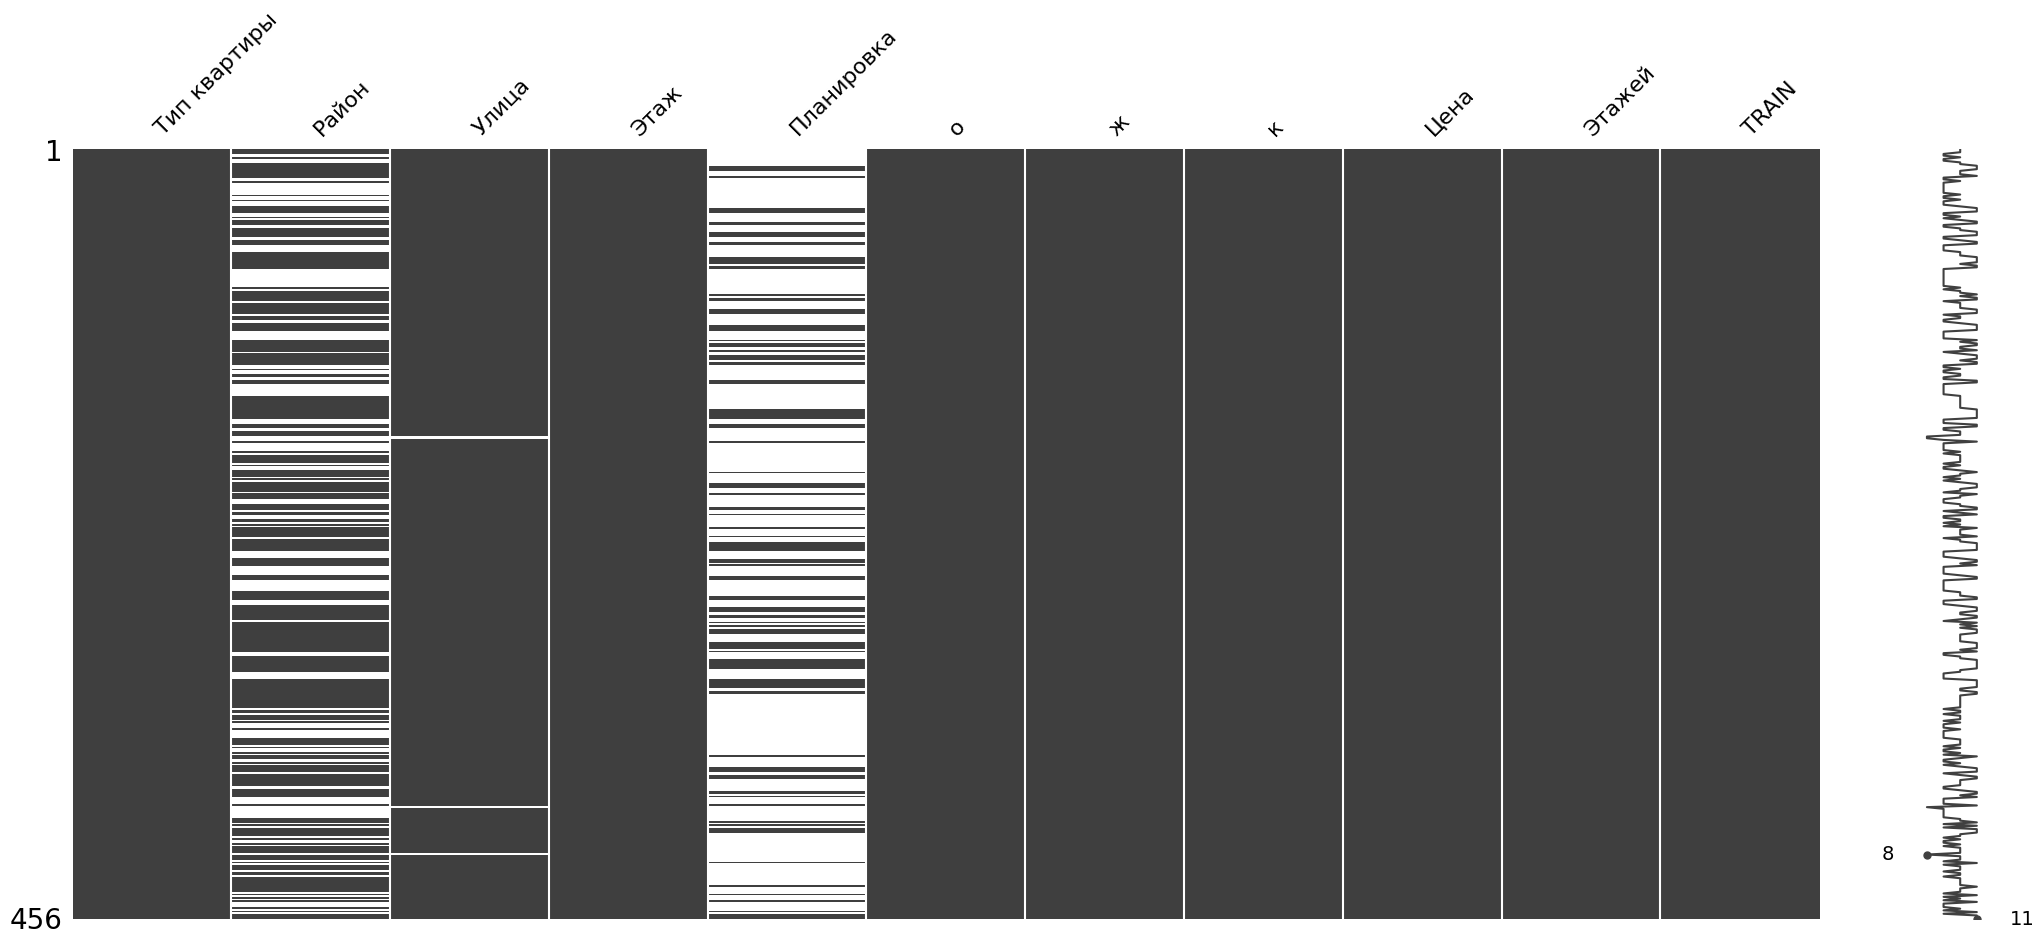

In [20]:
missingno.matrix(df);

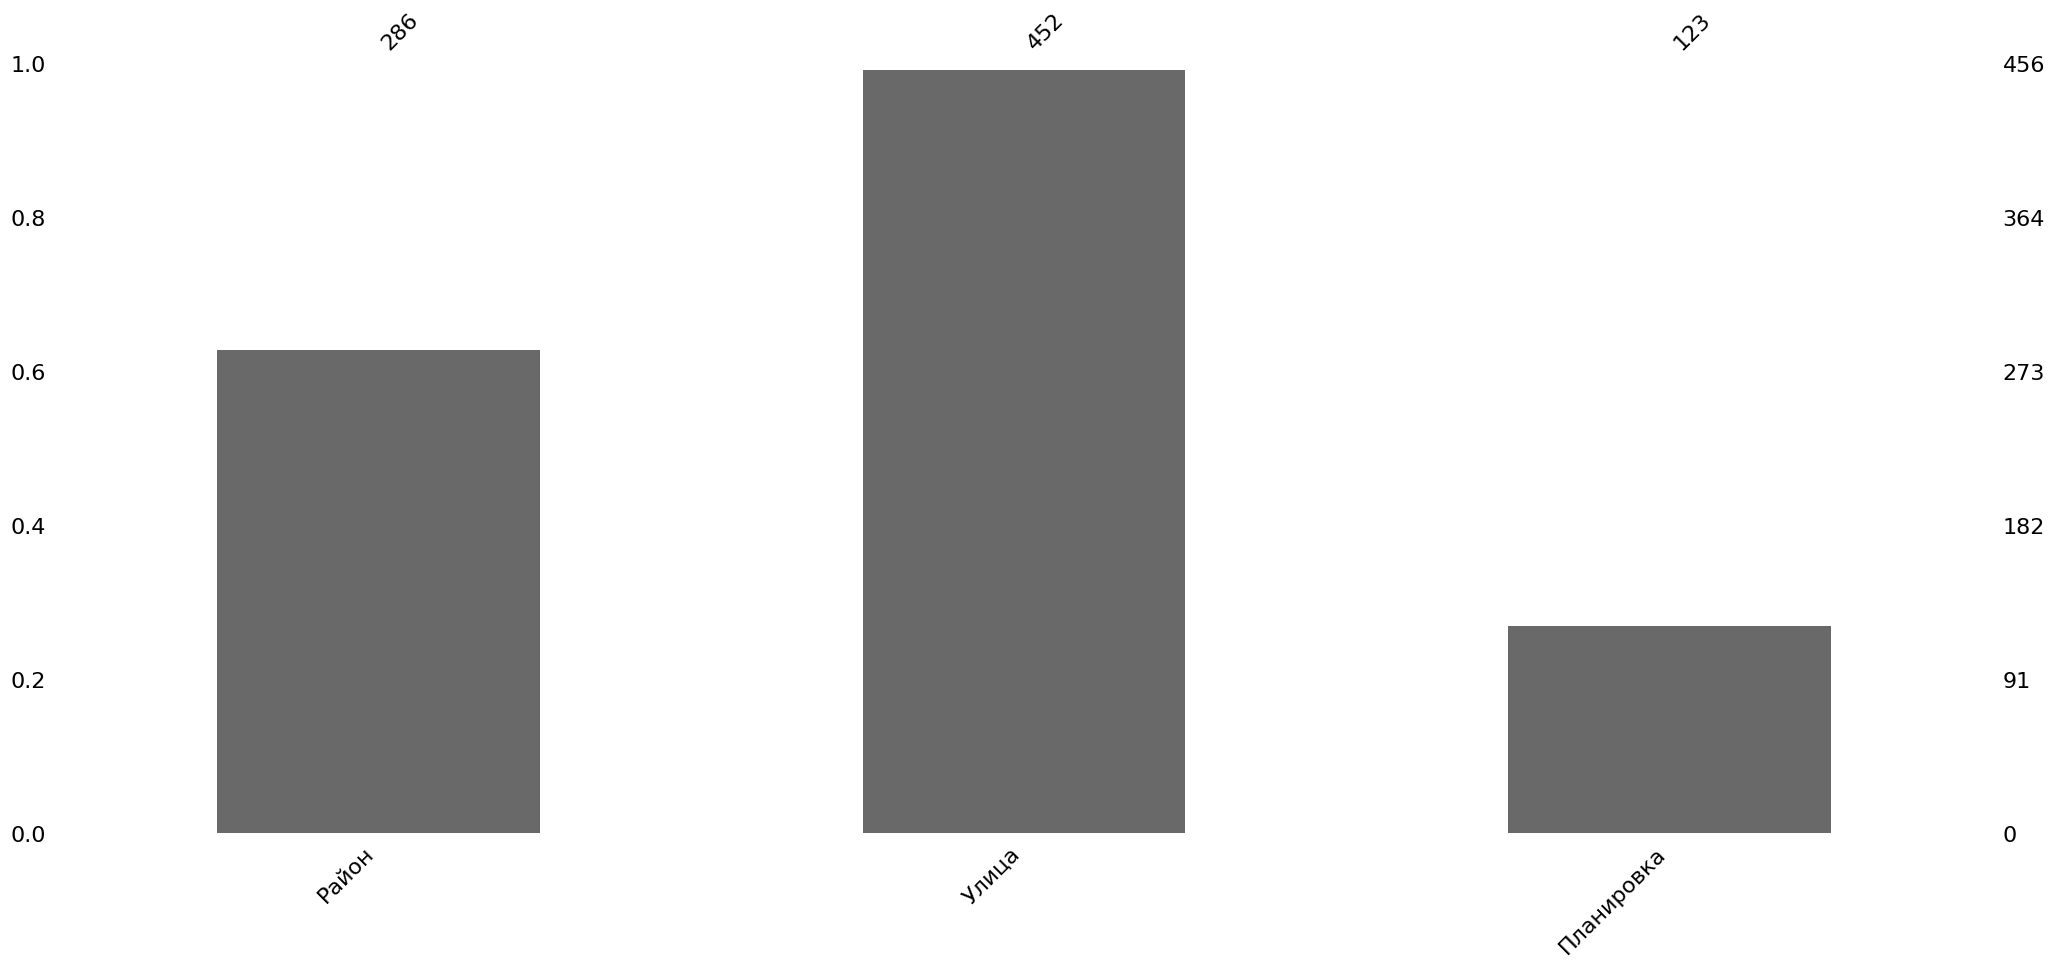

In [21]:
missingno.bar(df, filter='bottom', n=3);

## Outliers
### Showing of boxplots

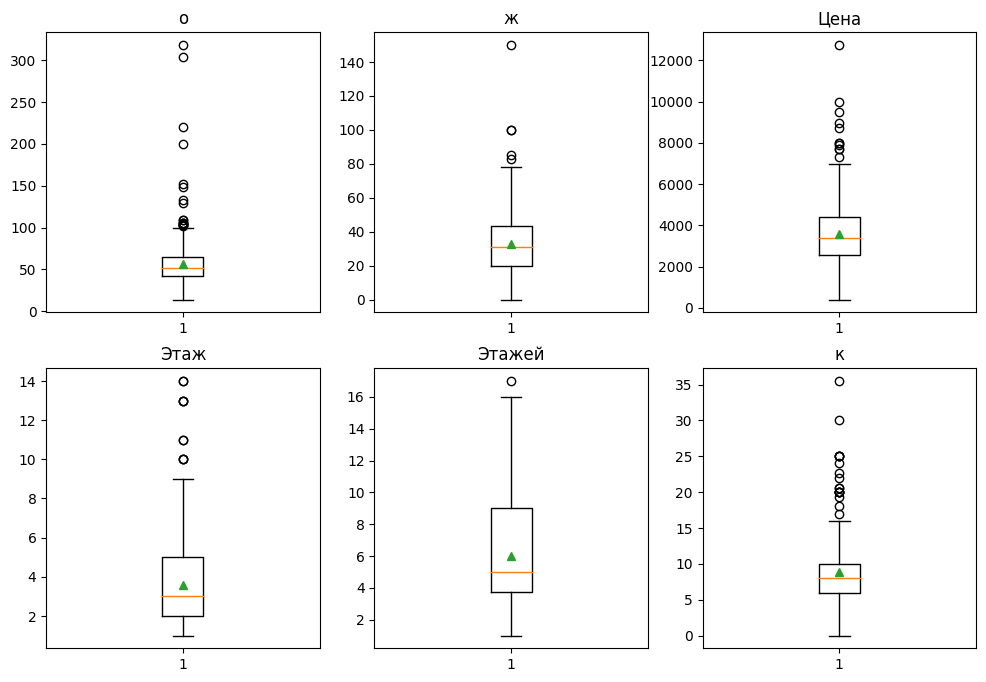

In [22]:
# Define columns to plot
plot_columns = set(df.columns.to_list()) - set(categ_columns + [TRAIN])

# Create figure with [rows x cols] graphs
cols = 3
rows = math.ceil((len(plot_columns)) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(12, rows*4))

# Plot graphs
for i, column in enumerate(plot_columns):
    if rows == 1:
        idx = i%cols
    else:
        idx = (i//cols, i%cols)
    axs[idx].boxplot(df_linear_ml.loc[df_linear_ml[column].notna(), column], showmeans=True)
    axs[idx].set_title(column)

In [23]:
outliers = {}
outliers_num = {}
for column in plot_columns:
    # Calculate Q1, Q3, IQR
    Q1 = df_linear_ml[column].quantile(0.25)
    Q3 = df_linear_ml[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate indices of rows
    outliers[column] = list(df_linear_ml.loc[(~df_linear_ml[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR))
                            & (df_linear_ml[column].notna()), column].index)
    outliers_num[column] = len(outliers[column])

print('Number of outliers per column:')
pd.Series(outliers_num)

Number of outliers per column:


о         18
ж          5
Цена      11
Этаж      10
Этажей     1
к         19
dtype: int64

# Categorical encoding

In [24]:
encoder = OneHotEncoder(sparse_output=False, min_frequency=7)

df_encoded = pd.DataFrame(encoder.fit_transform(df[categ_columns]), df.index, encoder.get_feature_names_out())

df_encoded = pd.concat([df, df_encoded], axis=1).drop(columns=categ_columns)

# Data splitting

In [25]:
# Split data
x = df.drop(columns=[TRAIN, TARGET])
y = df[TARGET]
x_train = df.loc[df[TRAIN], :].drop(columns=[TRAIN, TARGET])
x_valid = df.loc[~df[TRAIN], :].drop(columns=[TRAIN, TARGET])
y_train = df.loc[df[TRAIN], TARGET]
y_valid = df.loc[~df[TRAIN], TARGET]

# Split encoded data
x_encoded = df_encoded.drop(columns=[TRAIN, TARGET])
y_encoded = df_encoded[TARGET]
x_train_encoded = df_encoded.loc[df_encoded[TRAIN], :].drop(columns=[TRAIN, TARGET])
x_valid_encoded = df_encoded.loc[~df_encoded[TRAIN], :].drop(columns=[TRAIN, TARGET])
y_train_encoded = df_encoded.loc[df_encoded[TRAIN], TARGET]
y_valid_encoded = df_encoded.loc[~df_encoded[TRAIN], TARGET]

# Print data shape
print('Shapes:', x.shape, x_train.shape, x_valid.shape, y.shape, y_train.shape, y_valid.shape)
print('Shapes:', x_encoded.shape, x_train_encoded.shape, x_valid_encoded.shape, y_encoded.shape,
      y_train_encoded.shape, y_valid_encoded.shape)

Shapes: (456, 9) (364, 9) (92, 9) (456,) (364,) (92,)
Shapes: (456, 41) (364, 41) (92, 41) (456,) (364,) (92,)


# Dummy Regressor

In [26]:
def evaluate(model, x_train, y_train, x_valid, y_valid):
    pred_train = model.predict(x_train)
    pred_valid = model.predict(x_valid)
    
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_valid = mean_absolute_error(y_valid, pred_valid)
    
    rmse_train = math.sqrt(mean_squared_error(y_train, pred_train))
    rmse_valid = math.sqrt(mean_squared_error(y_valid, pred_valid))

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_valid = mean_absolute_percentage_error(y_valid, pred_valid)
    
    print(f'Training MAE:    {int(mae_train)} т.р.')
    print(f'Validation MAE:  {int(mae_valid)} т.р.')
    print()
    print(f'Training RMSE:   {int(rmse_train)} т.р.')
    print(f'Validation RMSE: {int(rmse_valid)} т.р.')
    print()
    print(f'Training MAPE:   {(mape_train*100):.2f} %')
    print(f'Validation MAPE: {(mape_valid*100):.2f} %')
    
    return mae_train, mae_valid, rmse_train, rmse_valid, mape_train, mape_valid

In [27]:
# Define model
model = DummyRegressor()

# Train model
model.fit(x_train, y_train)

# Evaluate model
evaluate(model, x_train, y_train, x_valid, y_valid);

Training MAE:    1185 т.р.
Validation MAE:  1186 т.р.

Training RMSE:   1598 т.р.
Validation RMSE: 1513 т.р.

Training MAPE:   50.46 %
Validation MAPE: 42.88 %


# Decision Tree Regressor
## Fit

In [28]:
%%time
model_file = MODELS_PATH + 'decision_tree.pickle'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    # Train model
    model = DecisionTreeRegressor(random_state=RANDOM_STATE)
    model.fit(x_train_encoded, y_train_encoded)

    # Save model
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 997 µs, sys: 1.51 ms, total: 2.51 ms
Wall time: 2.12 ms


## Evaluate

In [29]:
evaluate(model, x_train_encoded, y_train_encoded, x_valid_encoded, y_valid_encoded);

Training MAE:    0 т.р.
Validation MAE:  755 т.р.

Training RMSE:   5 т.р.
Validation RMSE: 1117 т.р.

Training MAPE:   0.02 %
Validation MAPE: 22.68 %


**Comments**
___
The model has overfitted. Searching for hyperparameter is needed.

# Random Forest Regressor
## Fit

In [30]:
%%time
model_file = MODELS_PATH + 'random_forest.pickle'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    # Train model
    model = RandomForestRegressor(n_estimators=100, max_features=0.3,
                                  n_jobs=-1, random_state=RANDOM_STATE)
    model.fit(x_train_encoded, y_train_encoded)

    # Save model
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 2.46 ms, sys: 2.36 ms, total: 4.81 ms
Wall time: 5.6 ms


## Evaluate

In [31]:
evaluate(model, x_train_encoded, y_train_encoded, x_valid_encoded, y_valid_encoded);

Training MAE:    229 т.р.
Validation MAE:  520 т.р.

Training RMSE:   363 т.р.
Validation RMSE: 743 т.р.

Training MAPE:   9.46 %
Validation MAPE: 18.03 %


# Gradient Boosting Regressor
## Fit

In [32]:
%%time
model_file = MODELS_PATH + 'gradient_boosting.pickle'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    # Train model
    model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=RANDOM_STATE)
    model.fit(x_train_encoded, y_train_encoded)

    # Save model
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 1.66 ms, sys: 1.2 ms, total: 2.86 ms
Wall time: 2.91 ms


## Evaluate

In [33]:
evaluate(model, x_train_encoded, y_train_encoded, x_valid_encoded, y_valid_encoded);

Training MAE:    356 т.р.
Validation MAE:  553 т.р.

Training RMSE:   498 т.р.
Validation RMSE: 805 т.р.

Training MAPE:   15.55 %
Validation MAPE: 19.45 %


# CatBoost Regressor
## Fit

In [34]:
%%time
model_file = MODELS_PATH + 'catboost' + '.cbm'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    model = CatBoostRegressor()
    model.load_model(model_file)
else:
    # Train model
    iterations = 10000
    learning_rate = 0.01
    early_stopping_rounds = 2000
    train_pool = Pool(x_train.fillna('None'), y_train, cat_features=categ_columns)
    valid_pool = Pool(x_valid.fillna('None'), y_valid, cat_features=categ_columns)
    model = CatBoostRegressor(iterations,
                              learning_rate,
                              early_stopping_rounds=early_stopping_rounds,
                              random_seed=RANDOM_STATE,
                              train_dir=MODELS_PATH + 'catboost/',
                              verbose=250)
    model.fit(train_pool,
              eval_set=valid_pool,
              plot=True)
    
    # Save model
    model.save_model(model_file)

CPU times: user 1.23 ms, sys: 3.43 ms, total: 4.66 ms
Wall time: 12.9 ms


## Evaluate

In [35]:
evaluate(model, x_train.fillna('None'), y_train, x_valid.fillna('None'), y_valid);

Training MAE:    327 т.р.
Validation MAE:  522 т.р.

Training RMSE:   454 т.р.
Validation RMSE: 706 т.р.

Training MAPE:   12.82 %
Validation MAPE: 17.54 %


# Pipeline
## Prepare data

In [36]:
# Get data as a list of dicts
test_indices = [0, 1, 2]
x_test = x_valid.fillna('None').iloc[test_indices, :].to_dict('records')

# Convert data to pandas DataFrame
x_test = pd.DataFrame(x_test)
x_test

,Тип квартиры,Район,Улица,Этаж,Планировка,о,ж,к,Этажей
0,Трехкомнатная,None,ленина,5,None,80.7,60.0,9.0,5
1,Трехкомнатная,None,ленинградская,1,None,70.0,45.0,12.0,4
2,Трехкомнатная,None,ленина,5,None,57.7,40.0,8.0,9


## Load model

In [37]:
model_file = MODELS_PATH + 'catboost' + '.cbm'
model = CatBoostRegressor()
model.load_model(model_file);

## Predict

In [38]:
result = model.predict(x_test)
result

array([6772.66603549, 5164.36829973, 3844.98673355])